<img src="https://raw.githubusercontent.com/Qiskit/qiskit-tutorials/master/images/qiskit-heading.png" width="1000 px" align="left">

annaphan@au.ibm.com <br>_1 February 2019_

In [1]:
# This notebook can be presented as a deck by uncommenting and running:
#!jupyter nbconvert ./AP-qiskit_intro.ipynb --to slides --post serve

# Or by installing RISE: https://damianavila.github.io/RISE/.

# Outline
* IBM Quantum Hardware
* Qiskit Overview
* Qiskit Demonstrations
  - Qiskit Terra Transpiler
  - Qiskit Ignis $T_1$ Measurement
  - Qiskit Aer Noise Simulation
  - Qiskit Aqua Quantum Machine Learning

_Please interject with questions, comments, or corrections._

# IBM Quantum Hardware

* IBM Q Experience (QX)
  - Previous:
    * 5 qubit device (Yorktown)
    * 16 qubit device (Rüschlikon)
  - Current:
    * 5 qubit device (Tenerife)
    * 14 qubit device (Melbourne)
* IBM Q Network
  - Previous: 20 qubit device (Austin)
  - Current: 20 qubit device (Tokyo)
  - Future: 50 qubit device
  
This [getting started tutorial notebook](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/basics/getting_started_with_qiskit_terra.ipynb) will show you how to gain access to the QX hardware.

In [2]:
from qiskit import IBMQ
IBMQ.load_accounts(hub=None)

from qiskit.tools.monitor import backend_overview
backend_overview()

ibmq_16_melbourne           ibmqx4
-----------------           ------
Num. Qubits:  14            Num. Qubits:  5
Pending Jobs: 1             Pending Jobs: 8
Least busy:   True          Least busy:   False
Operational:  True          Operational:  True
Avg. T1:      53.9          Avg. T1:      51.9
Avg. T2:      68.0          Avg. T2:      18.9





<img src="https://cdn-images-1.medium.com/max/716/1*PCitWbwqQPJIlWJpIOv8sA.jpeg" width="1500 px" align="center">

Terra, the ‘earth’ element, is the foundation on which the rest of the software lies. Terra provides a bedrock for composing quantum programs at the level of circuits and pulses, to optimize them for the constraints of a particular device, and to manage the execution of batches of experiments on remote-access devices. Terra defines the interfaces for a desirable end-user experience, as well as the efficient handling of layers of optimization, pulse scheduling and backend communication.

Aqua, the ‘water’ element, is the element of life. To make quantum computing live up to its expectations, we need to find real-world applications. Aqua is where algorithms for NISQ computers are built. These algorithms can be used to build applications for quantum computing. Aqua is accessible to domain experts in chemistry, optimization or AI, who want to explore the benefits of using quantum computers as accelerators for specific computational tasks, without needing to worry about how to translate the problem into the language of quantum machines.

Ignis, the ‘fire’ element, is dedicated to fighting noise and errors and to forging a new path. This includes better characterization of errors, improving gates, and computing in the presence of noise. Ignis is meant for those who want to design quantum error correction codes, or who wish to study ways to characterize errors through methods such as tomography, or even to find a better way for using gates by exploring dynamical decoupling and optimal control. While we have already released parts of this element as part of libraries in Terra, an official stand-alone release will come soon.

Aer, the ‘air’ element, permeates all Qiskit elements. To really speed up development of quantum computers we need better simulators, emulators and debuggers. At IBM Q, we have built high-quality, high-performance simulators and continue to improve their scalability and features. Aer will help us understand the limits of classical processors by demonstrating to what extent they can mimic quantum computation. Furthermore, we can use Aer to verify that current and near-future quantum computers function correctly. This can be done by stretching the limits of simulation to accommodate 50+ qubits with reasonably high depth, and by simulating the effects of realistic noise on the computation.

## Basic Qiskit Example

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, IBMQ, execute

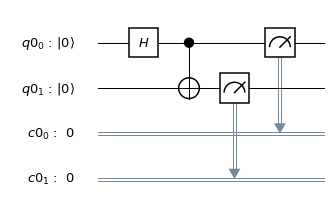

In [4]:
q = QuantumRegister(2)             # Create a Quantum Register with 2 qubits
c = ClassicalRegister(2)           # Create a Classical Register with 2 bits
bell_circuit = QuantumCircuit(q,c) # Create a Quantum Circuit with the registers

bell_circuit.h(q[0])        # Perform a Hadamard on the first qubit
bell_circuit.cx(q[0], q[1]) # Perform a CNOT between the first and second qubits
bell_circuit.measure(q,c)   # measure the quantum registers

bell_circuit.draw(output="mpl") # Draw the circuit using matplotlib

In [5]:
# Simulate the circuit
sim_backend = Aer.get_backend('qasm_simulator')
sim_job = execute(bell_circuit, sim_backend, shots=1024)
sim_counts = sim_job.result().get_counts(bell_circuit)
print(sim_counts)

{'11': 515, '00': 509}


In [6]:
# Select the least busy device with more than 6 qubits to run the circuit - note that this always returns 
from qiskit.providers.ibmq import least_busy
backend = least_busy(IBMQ.backends(filters = lambda x: x.configuration().n_qubits > 6 and
                                                       not x.configuration().simulator))
status = backend.status().to_dict()
print("The best backend is " + backend.name() + " with pending jobs " + str(status["pending_jobs"]))

The best backend is ibmq_16_melbourne with pending jobs 1


In [7]:
# Run the circuit on the selected device
dev_job = execute(bell_circuit, backend=backend, shots=1024)
dev_counts = dev_job.result().get_counts(bell_circuit)
print(dev_counts)

{'11': 366, '01': 86, '00': 521, '10': 51}


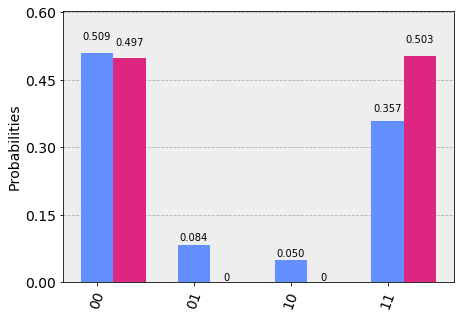

In [8]:
# Visualise the results as a histogram
from qiskit.tools.visualization import plot_histogram
plot_histogram([dev_counts,sim_counts])

# Qiskit Terra

Right now (Version 0.7) Terra’s core service is the compilation and execution of quantum circuits for arbitrary backends, and shipping jobs to backends
  * Terra can take the same circuit object and compile and run it on any quantum hardware or simulator
  * It also includes operations for circuit construction, including loading QASM
  * Terra also optimizes the circuit, and allows for plug-and-play transpilation options
  * Several local simulators are currently included in Terra, but these will soon move to Aer
  * Terra has IBM Q API connections built in - it will send your job to your desired backend and collect the results

In the future, Terra will include:

  * OpenPulse, pulse level control of IBM Quantum Hardware
  * More convenience operations for constructing sophisticated circuits

Keep in mind:

  * Terra is not a language per se, but more of a large piece of infrastructure. Some code may seem unnecessary for the one thing you’re doing, but in many cases it’s necessary for Qiskit to be robust.
  * Qiskit is very much a work in progress. It is changing rapidly to converge toward the needs of its users. We welcome and are grateful for feedback.

## Qiskit Terra Transpiler

The transpiler is the workhorse of Terra. It’s how we keep circuits backend agnostic and compilable for arbitrary quantum hardware. The transpiler transpiles circuits into circuits allowing the end user to view and understand what individual transpiler passes are doing to their circuit. Here's a sample circuit that won't fit nicely on IBM's hardware:

In [9]:
from qiskit.transpiler import transpile, PassManager
from qiskit.transpiler.passes import BasicSwap, CXCancellation, LookaheadSwap, StochasticSwap
from qiskit.mapper import CouplingMap

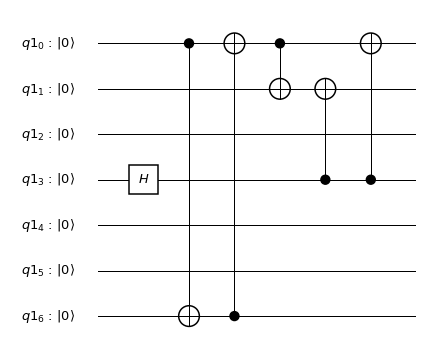

In [10]:
qr = QuantumRegister(7)
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.cx(qr[0], qr[6])
tpl_circuit.cx(qr[6], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw(output="mpl")

The most naive thing we can do is simply move qubits around greedily with swaps. That's what `BasicSwap` does:

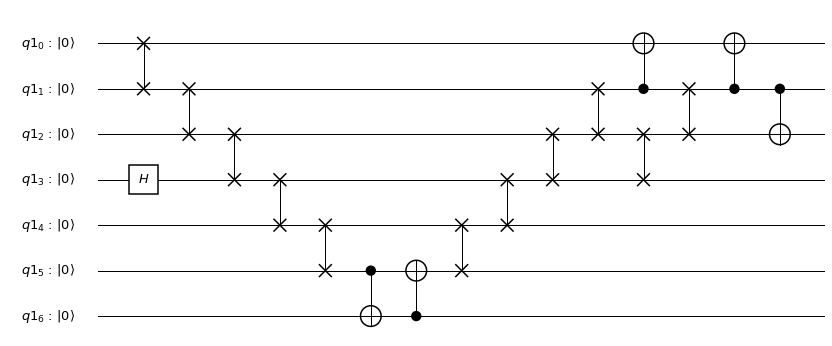

In [11]:
coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

simulator = Aer.get_backend('qasm_simulator')
coupling_map = CouplingMap(couplinglist=coupling)
pass_manager = PassManager()
pass_manager.append([BasicSwap(coupling_map=coupling_map)])
basic_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
basic_circ.draw(output="mpl")

It's a solution, but it's not great. Let’s try [Sven Jandura's LookaheadSwap](https://medium.com/qiskit/improving-a-quantum-compiler-48410d7a7084), submitted for the [2018 QISKit
Developer Challenge](https://www.ibm.com/blogs/research/2018/08/winners-qiskit-developer-challenge/). Sven’s swap pass was merged into Terra, and we will have two more passes from [other](https://medium.com/qiskit/how-computer-aided-design-helped-me-winning-the-qiskit-developer-challenge-4b1b60c8930f) [winners](https://medium.com/qiskit/constraints-on-quantum-circuits-and-getting-around-them-7de973bd1a18) of the Qiskit Developer Challenge soon! 

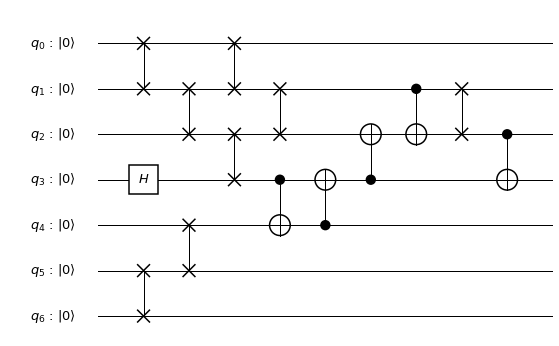

In [12]:
pass_manager = PassManager()
pass_manager.append([LookaheadSwap(coupling_map=coupling_map)])
lookahead_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
lookahead_circ.draw(output="mpl")

Better! One more try with StochasticSwap:

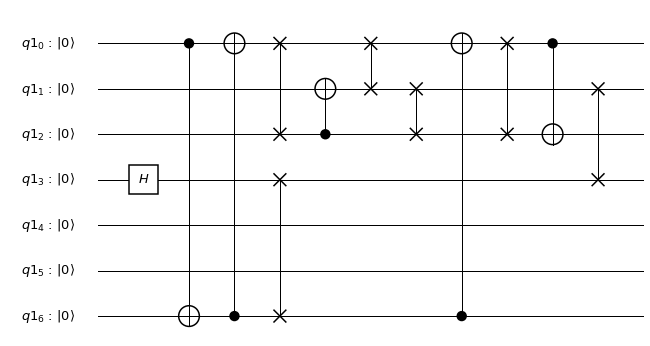

In [13]:
pass_manager = PassManager()
pass_manager.append([StochasticSwap(coupling_map=coupling_map)])
stoch_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
stoch_circ.draw(output="mpl")

Hm... this doesn't look right, there's swaps and gates between unconnected qubits. Looking through the Qiskit Terra GitHub [issues](https://github.com/Qiskit/qiskit-terra/issues) and [pull requests](https://github.com/Qiskit/qiskit-terra/pulls), this has been [documented](https://github.com/Qiskit/qiskit-terra/issues/1573) and [addressed](https://github.com/Qiskit/qiskit-terra/pull/1722) for the next release.

We’re constructing a diverse set of passes, many user contributed, to meet the wide-ranging needs and mapping scenarios of circuits in the wild. Right now this all happens behind the scenes for many users, but we hope that these tools make digging into transpilation much more accessible to those attempting to squeeze as much performance as possible out of their experiments on hardware.

Finally, let's see what the default transpiler does to our circuit to be able to run on a real backend. Note that this will include unrolling into the {U, CX} basis, including the swaps.

In [14]:
tpl_ibmq_circ = transpile(tpl_circuit, backend=backend)
tpl_ibmq_circ.draw(line_length=200)

# Qiskit Ignis

Qiskit Ignis will be released later this year and will include tools for system characterisation and banchmarking such as state and process tomography, measurement correction, and more...

It is already possible to do some of these operations in Qiskit Terra, and here we go through an example where we estimate $T_1$ for one of the qubits on the 14 qubit ladder device, following this [relaxation and decoherence tutorial notebook](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/ignis/relaxation_and_decoherence.ipynb).

## Qiskit 'Ignis' $T_1$ Measurement

A simple way of estimating the $T_{1}$ time is to collect statistics about the decay curve for $P_{1}(t)$ when the qubit is initialized to $|1\rangle$. This can be done by choosing a variety of times $t_{1}, t_{2}, \cdots t_{N}$, and then running the following experiment many times:

  * Prepare the qubit in $|1\rangle$.
  * Wait a delay time $t_{j}$.
  * Measure the qubit in the $|0\rangle, |1\rangle$ basis.

An estimate of $P_{1}(t_{j})$ is the number of times the qubit was observed to be in $|1\rangle$, divided by the total number of times the experiment was repeated. Given several estimated values of $P_{1}$ for a variety of $(t_{j})$, we can fit the resulting decay curve is fit to an exponential and extract an estimate of $\Gamma_{1}$, and hence, the $T_{1}$ time.

Qiskit does not currently support delays of arbitrary length, so for now, we just append a series of identity operations after the initial excitation pulse. Each identity operation has the same duration of a single-qubit gate and is followed by a shorter buffer time. These parameters are backend dependent.

In [15]:
# Function that adds N identity gates to the qr quantum register in the given circuit
def pad_id(circuit,N,qr):
    for j in range(N):
        circuit.barrier(qr)
        circuit.iden(qr)
    return circuit    

In [16]:
# Select qubit whose T1 is to be measured
t1_qubit = 4

# Determine the number of times to run each circuit
t1_shots = 1024

# Creating registers
qr = QuantumRegister(5)
cr = ClassicalRegister(5)

# the delay times are all set in terms of single-qubit gates
# so we need to calculate the time from these parameters
pulse_length = 100 # single-qubit gate time 
buffer_length = 10 # spacing between pulses
unit = 'ns'

steps = 10
gates_per_step = 120
max_gates = (steps - 1) * gates_per_step + 1
tot_length = buffer_length + pulse_length
time_per_step = gates_per_step * tot_length
t1_qc_dict = {}
for i in range(steps):
    step_num = 'step_%s'%(str(i))
    t1_qc_dict.update({step_num:QuantumCircuit(qr, cr)})
    t1_qc_dict[step_num].x(qr[t1_qubit])
    t1_qc_dict[step_num] = pad_id(t1_qc_dict[step_num], gates_per_step * i, qr[t1_qubit])
    t1_qc_dict[step_num].barrier(qr[t1_qubit])
    t1_qc_dict[step_num].measure(qr[t1_qubit], cr[t1_qubit])
t1_circuits = list(t1_qc_dict.values())    

In [17]:
# Run all the circuits
t1_job = execute(t1_circuits, backend, shots=t1_shots)

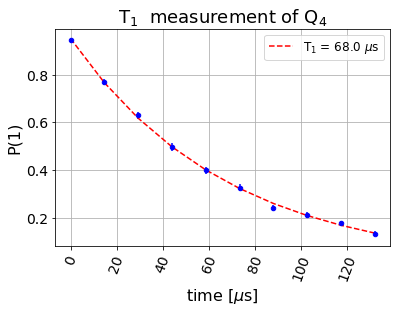

a: 0.95 ± 0.02
T1: 67.88 µs ± 3.29 µs
c: 0.0 ± 0.02


In [18]:
from qiskit.tools.qcvv.fitters import exp_fit_fun, plot_coherence
from scipy.optimize import curve_fit
import numpy as np

# arrange the data from the run
result_t1 = t1_job.result()
keys_0_1 = list(result_t1.get_counts(t1_qc_dict['step_0']).keys())
excited_key = keys_0_1[0] if int(keys_0_1[1]) == 0 else keys_0_1[1] # get the key of the excited state
data = np.zeros(len(t1_qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(t1_qc_dict.keys()))

# change unit from ns to microseconds
plot_factor = 1
if unit.find('ns') >- 1:
    plot_factor = 1000
    punit = '$\\mu$s'
# calculate the time steps in microseconds
xvals = time_per_step * np.linspace(0, len(t1_qc_dict.keys()), len(t1_qc_dict.keys())) / plot_factor  

for i,key in enumerate(t1_qc_dict.keys()):
    # get the data in terms of counts for the excited state normalised to the total number of counts
    data[i] = float(result_t1.get_counts(t1_qc_dict[key])[excited_key])/t1_shots
    sigma_data[i] = np.sqrt(data[i]*(1-data[i]))/np.sqrt(t1_shots)

# fit the data to an exponential    
fitT1, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,2,0],[1.,500,1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT1, exp_fit_fun, punit, 'T$_1$ ', t1_qubit)

print("a: " + str(round(fitT1[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T1: " + str(round(fitT1[1],2))+ " µs" + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("c: " + str(round(fitT1[2],2)) + u" \u00B1 " + str(round(ferr[2],2)))

The last calibration of $𝑇_1$ for this qubit was measured to be:

In [19]:
print(backend.properties().qubits[t1_qubit][0].value, backend.properties().qubits[t1_qubit][0].unit)

59.151827213713545 µs


# Qiskit Aer

Qiskit Aer is a high performance local simulation provider that includes: 

1. The `Aer` qiskit provider containing three simulator backends:
  * `QasmSimulator`: simulates a quantum circuit and returns measurement outcomes
  * `StateVectorSimulator`: simulates a quantum circuit and returns the final statevector
  * `UnitarySimulator`: simulates the unitary matrix for a quantum circuit
  

2. A `Noise` module containing advanced noise modeling features for the `QasmSimulator`:
  * `NoiseModel` class for building custom noise models
  * `Errors` submodule for constructing custom errors
  * `Device` submodule for generating an automatic device noise model


3. A `utils` module that will contain additional simulator utilities. (*For now this only contains `qobj_utils` which is designed to help with hacks that aren't yet supported by the Terra circuit API.*)

You saw an example of the `QasmSimulator` in use earlier. For examples of the `StateVectorSimulator` and `UnitarySimulator`, see the [simulators tutorial notebook](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aer/aer_provider.ipynb).

## Qiskit Aer Noise Simulation

The noise model contains Python classes to build customized noise models for simulation. It also contains functions to automatically generate a noise model. The automatic noise generation can be seen in the [device noise tutorial notebook](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aer/device_noise_simulation.ipynb) and won't be covered here.

The noise module contains three key classes:

1. The `NoiseModel` class which stores a noise model used for noisy simulation
2. The `QuantumError` class which describes errors that effect the state of qubits. These errors can be applied after gates or reset instructions, or before measure instructions.
3. The `ReadoutError` class which describes errors that effect the state of memory bits, and is applied after measurements.

The error classes are used to construct errors which may then be added to a `NoiseModel` to be applied to specific circuit instructions.

### Standard Quantum Errors

Rather than deal with the `QuantumError` object directly, many helper functions exist to automatically generate a specific type of parameterized quantum error. These are contained in the `noise.errors` submodule and include functions for many common errors types used in quantum computing research. The function names and the type of error they return are:

| Standard error function | Details |
| ---: | :--- |
| `kraus_error` | a general n-qubit CPTP error channel given as a list of Kraus matrices $[K_0, ...]$. |
| `mixed_unitary_error` | an n-qubit mixed unitary error given as a list of unitary matrices and probabilities $[(U_0, p_0),...]$. |
| `coherent_unitary_error` | an n-qubit coherent unitary error given as a single unitary matrix $U$. |
| `pauli_error` | an n-qubit Pauli error channel (mixed unitary) given as a list of Pauli's and probabilities $[(P_0, p_0),...]$ |
| `depolarizing_error` | an n-qubit depolarizing error channel parameterized by a depolarizion probability $p$. |
| `thermal_relaxation_error` | a single qubit thermal relaxation channel parameterized by relaxation time constants $T_1$, $T_2$, gate time $t$, and excited state thermal population $p_1$. |
| `phase_amplitude_damping_error` | A single-qubit generalized combined phase and amplitude damping error channel given by an amplitude damping parameter $\lambda$, a phase damping parameter $\gamma$, and an excited state thermal population $p_1$. |
| `amplitude_damping_error` |  A single-qubit generalized amplitude damping error channel given by an amplitude damping parameter $\lambda$, and an excited state thermal population $p_1$. |
| `phase_damping_error` |  A single-qubit phase damping error channel given by a phase damping parameter $\gamma$ |

### Error example: Depolarizing errors

For example to construct a 5% single-qubit depolarizing error:

In [20]:
# Import all standard error objects
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import *

In [21]:
# Construct a 1-qubit depolarizing error
depol1 = depolarizing_error(0.05, 1, standard_gates=True) 
print(depol1)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0125, QobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.0125, QobjInstructions = [[{'name': 'y', 'qubits': [0]}]
  P(2) = 0.0125, QobjInstructions = [[{'name': 'z', 'qubits': [0]}]
  P(3) = 0.9625, QobjInstructions = [[{'name': 'id', 'qubits': [0]}]


Next we need to add the error to a noise model.

### Adding errors to a Noise Model

When adding a quantum error to a noise model we must specify the type of *instruction* that it acts on, and what qubits to apply it to. There are three cases for Quantum Errors:
 
 1. All-qubit quantum error
 2. Specific qubit quantum error
 3. Non-local quantum error

#### All-qubit quantum error

This applies the same error to any occurence of an instruciton, regardless of which qubits it acts on.

It is added as `noise_model.add_all_qubit_quantum_error(error, instructions)`:

In [22]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
noise_model.add_all_qubit_quantum_error(depol1, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Instructions with noise: ['u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']



#### Specific qubit quantum error

This applies the error to any occurence of an instruction acting on a specified list of qubits. Note that the order of the qubit matters: For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0] for example.

It is added as `noise_model.add_quantum_error(error, instructions, qubits)`:

In [23]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
noise_model.add_quantum_error(depol1, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Instructions with noise: ['u2', 'u3', 'u1']
  Specific qubit errors: [('u1', [0]), ('u2', [0]), ('u3', [0])]


#### Non-local qubit quantum error

This applies an error to a specific set of noise qubits after any occurence of an instruction acting on a specific of gate qubits.

It is added as `noise_model.add_quantum_error(error, instructions, instr_qubits, error_qubits)`:

In [24]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error on qubit 2 forall single qubit u1, u2, u3 gates on qubit 0 
noise_model.add_nonlocal_quantum_error(depol1, ['u1', 'u2', 'u3'], [0], [2])
 
# Print noise model info
print(noise_model)

NoiseModel:
  Instructions with noise: ['u2', 'u3', 'u1']
  Non-local specific qubit errors: [('u1', [0], [2]), ('u2', [0], [2]), ('u3', [0], [2])]


### Noise Model Example: Bit-flip error model

Let's consider a simple toy noise model example common in quantum information theory research:

* When applying a single qubit gate, flip the state of the qubit with probability `p_gate1`.
* When applying a 2-qubit gate apply single-qubit errors to each qubit.
* When reseting a qubit reset to 1 instead of 0 with probability `p_reset`.
* When measuring a qubit, flip the state of the qubit before with probability `p_meas`.

In [25]:
# Example error probabilities
p_gate1 = 0.05
p_reset = 0.03
p_meas = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.kron(error_gate1)

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_model)

NoiseModel:
  Instructions with noise: ['reset', 'u2', 'u3', 'measure', 'u1', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


Now we have built a noise model, we need to execute it. Attaching a noise model to a simulation is done using the `noise_model` keyword argument.

**Important:** *When running a noisy simulation make sure you compile your qobj to the same basis gates as the noise model!*

This can be done using `noise_model.basis_gates`:

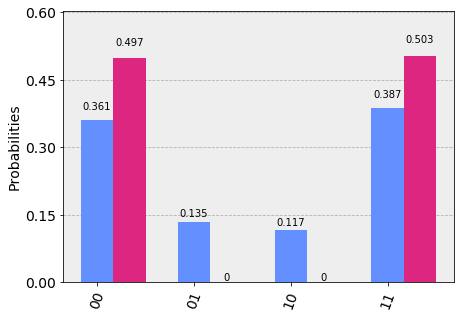

In [26]:
from qiskit.providers.aer import QasmSimulator
from qiskit import compile

# Compile previous Bell circuit using noise model basis gates
noise_qobj = compile(bell_circuit, simulator, basis_gates=noise_model.basis_gates)

# Run the noisy simulation
noise_result = simulator.run(noise_qobj, noise_model=noise_model).result()
noise_counts = noise_result.get_counts(bell_circuit)
plot_histogram([noise_counts,sim_counts])

# Qiskit Aqua
<img src="https://cdn-images-1.medium.com/max/896/1*wfBylzNphPJtCAHHE2x0AA.png" width="1500 px" align="center">

Aqua is:

  * An easy to use library for running many different quantum algorithms
  * A collection of reusable components which can be mixed and matched in different algorithms

Aqua is very practically driven:
  * We have real chemists and clients who are trying to get things done
  * It is exactly what you’d expect to spring out of rapid practical need… it is very function-driven and evolves rapidly
  * The guts are not so inviting in some places because of how rapidly it evolves and because of how it is engineered and optimised
  * If you need to do something, there is a good chance someone already put it in Aqua or should
    - Please send in feature requests!

Aqua is built to be highly extensible and have very easy to use interfaces


Aqua organises reusable components into buckets, elements of which can be substituted for one another:

  * Algorithms
  * Variational forms
  * Optimisers
  * Other smaller buckets (translators, QFTs, oracles, feature maps)

It is not so much a “I give you parameters, you give me back a circuit” library, because in most cases, running the algorithms is much more than just executing the circuit (e.g. VQE, q-kernel SVM, etc.)

It’s not even so much about “give me x component,” it’s more “execute this algorithm, with this set of components,” allowing you to mix and match or add your own components easily

There are many [tests](https://github.com/Qiskit/qiskit-aqua/tree/master/test), which give good examples of execution modes and components, as well as tutorials in the qiskit-tutorials repository in the [qiskit](https://github.com/Qiskit/qiskit-tutorials/tree/master/qiskit/aqua) and [community](https://github.com/Qiskit/qiskit-tutorials/tree/master/community/aqua) folders. 

To really understand what's going on under the covers, get an IDE and step through the code!

## Quantum Machine Learning with Support Vector Machines

**Q-Kernel SVM:** We use a standard classical SVM with a “quantum kernel.” The kernel is an $n \times n$ matrix ($n$ is the number of training samples), where matrix element $m, p$ is generated by running short variational circuits of the form $⟨$ variational_form($m$) $|$ variational_form($p$) $⟩$ for every point $m, p$ in the training set. Note that a single point $m$ is a list of features. This kernel extends the reach of the feature space beyond what we believe is possible classically.

**Q-Variational SVM:** To train, we input a sample as the initial state of a short variational circuit, with parameters, and read the result (mod $2$) to find the circuit’s classification. We optimise the parameters of the variational circuit classically to improve the model’s classification accuracy. For more information, see this [paper](https://arxiv.org/abs/1804.11326). *Warning: the variational svm can be very slow to converge.*



Let's attempt to fit a very nonlinear function, $f(x,y) = x \times y$:

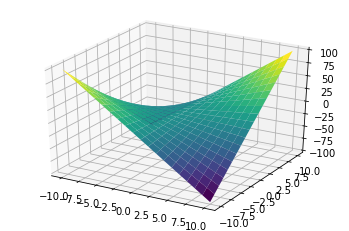

In [27]:
import matplotlib.pyplot as plt

def f(x, y):
    return x * y

x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

First we need to create the training and test data:

In [28]:
train_size = 50
test_size = 20

x_trn = (np.random.random(train_size)*2)-1
y_trn = (np.random.random(train_size)*2)-1
greater = [[x,y] for x,y in zip(x_trn,y_trn) if x*y >=0]
less = [[x,y] for x,y in zip(x_trn,y_trn) if x*y < 0]
training_data = {"greater": greater, "less":less}

x_tst = (np.random.random(test_size)*2)-1
y_tst = (np.random.random(test_size)*2)-1
greater = [[x,y] for x,y in zip(x_tst,y_tst) if x*y >=0]
less = [[x,y] for x,y in zip(x_tst,y_tst) if x*y < 0]
test_data = {"greater": greater, "less":less}

print(training_data)
print()
print(test_data)

{'greater': [[-0.9443972823233178, -0.41362403892103217], [-0.7913400235127677, -0.2336552348339167], [0.9861522582372322, 0.02769464406899802], [0.31976111378867245, 0.26756423295141785], [0.5948303792110496, 0.49018930234106595], [-0.6282086348615583, -0.875632390353202], [-0.24008101821956052, -0.10622253003181648], [0.5174425082519227, 0.5987036015506748], [-0.8605978613694598, -0.6958569507930179], [-0.9469590034658733, -0.6882832955614406], [0.7959177077994788, 0.5128571714309824], [0.34038286908439397, 0.3882137729615942], [-0.24030066926027138, -0.49361169385815185], [0.9765315829440895, 0.7845363181189542], [0.6357316527877896, 0.4748075577015882], [-0.40484967563369123, -0.2071134637834311], [0.529374266531089, 0.9003844973805977], [0.9381077466391632, 0.8712399530766262], [-0.3602692307379325, -0.6076744903583735], [0.02393060559566118, 0.9905137983209906], [-0.6042832675263923, -0.4358890051199016], [-0.7131162296729239, -0.4918977581403656], [-0.3236496895990406, -0.371659

Now let's use the data to train and then test the Qiskit Aqua `QSVMKernel` and `QSVMVariational` algorithms:

In [29]:
from qiskit_aqua import run_algorithm
from qiskit_aqua.input import SVMInput
from qiskit_aqua.algorithms import QSVMKernel
from qiskit_aqua.algorithms import QSVMVariational
import time

In [30]:
def aqua_qksvm_score(training_data, test_data, shots=1024):
    qksvm_params = {
        'problem':   {'name': 'svm_classification', 'random_seed': 10598},
        'algorithm': {'name': 'QSVM.Kernel'},
        'backend':   {'name': 'ibmq_qasm_simulator', 'shots': shots},
    }
    qksvm_input = SVMInput(training_data, test_data)
    t0 = time.process_time()
    kernel_result = run_algorithm(qksvm_params, qksvm_input)
    t1 = time.process_time()
    return kernel_result, (t1 - t0)/60

In [31]:
qksvm_result, qksvm_time = aqua_qksvm_score(training_data, test_data)
print("Classification success: {}%".format(qksvm_result['test_success_ratio'] * 100))
print("Process time: {0:6.2f} minutes".format(qksvm_time))

Classification success: 75.0%
Process time:   3.21 minutes


In [32]:
def aqua_variational_svm_score(training_data, test_data, shots=1024):
    variational_params = {
        'problem': {'name': 'svm_classification', 'random_seed': 10598},
        'algorithm': {'name': 'QSVM.Variational'},
        'backend':   {'name': 'ibmq_qasm_simulator', 'shots': shots},
        'optimizer': {'name': 'SPSA', 'max_trials': 200, 'save_steps': 1},
        'variational_form': {'name': 'RYRZ', 'depth': 3},
        'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2}
    }
    variational_input = SVMInput(training_data, test_data)
    t0 = time.process_time()
    variational_result = run_algorithm(variational_params, variational_input)
    t1 = time.process_time()
    return variational_result, (t1 - t0)/60

In [36]:
variational_result, variational_time = aqua_variational_svm_score(training_data, test_data)
print("Classification success: {}%".format(variational_result['test_success_ratio'] * 100))
print("Process time: {0:6.2f} minutes".format(variational_time))

Classification success: 70.0%
Process time:  25.23 minutes


Compare to classical SVMs:

In [34]:
from sklearn import svm

def classical_svm_score(samples_tr, labels_tr, samples_te, labels_te, kernel='linear'):
    model = svm.SVC(kernel=kernel,gamma='scale')
    model.fit(samples_tr, labels_tr)
    return model.score(samples_te, labels_te)

In [35]:
samples_train = list(zip(x_trn, y_trn))
samples_test = list(zip(x_tst, y_tst))
labels_train = [x*y>=0 for [x,y] in samples_train]
labels_test = [x*y>0 for [x,y] in samples_test]

score = {'rbf':[], 'linear':[], 'poly':[], 'sigmoid':[]}
for key in score:
    score[key] = classical_svm_score(samples_train, labels_train, samples_test, labels_test, kernel=key)
print(score)

{'rbf': 0.9, 'linear': 0.3, 'poly': 0.65, 'sigmoid': 0.45}


# Learning More

The [qiskit-tutorial](https://github.com/Qiskit/qiskit-tutorials) repository on Github has dozens of thoughtful and sophisticated tutorials. I highly recommend going through both the [qiskit](https://github.com/Qiskit/qiskit-tutorials/tree/master/qiskit) and [community](https://github.com/Qiskit/qiskit-tutorials/tree/master/community) directories. I learn new things every time I look through them, and reference them regularly.

The order in which I investigate if I'm confused about something:
* Look at the [tutorials](https://github.com/Qiskit/qiskit-tutorials/) for an example
* Look at the [code](https://github.com/Qiskit/qiskit-terra/tree/master/qiskit) directly to understand the behavior
* Look at the [examples](https://github.com/Qiskit/qiskit-terra/tree/master/examples) or [tests](https://github.com/Qiskit/qiskit-terra/tree/master/test) for something similar
* Debug in my IDE (many IBM researchers use [PyCharm](https://www.jetbrains.com/pycharm/)), relying heavily on inspecting objects during execution

Good luck and have fun using Qiskit!